In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, year, abs, regexp, lit
import duckdb
import pandas

# on écrit dans le projet dbt
db_path = "ventes/ventes_clean.duckdb"

## Création de l'environnement spark
Les traitements sont éxécutés uniquement en local.

In [2]:
spark = SparkSession.builder.appName("ventes").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

## Import des donnés
Le typage automatique nous convient.

In [3]:
df = spark.read.csv("ventes.csv", header=True, inferSchema=True)
print(df.dtypes)
df.printSchema()

[('id_transaction', 'int'), ('client_nom', 'string'), ('client_age', 'int'), ('client_ville', 'string'), ('produit_nom', 'string'), ('produit_categorie', 'string'), ('produit_marque', 'string'), ('prix_catalogue', 'int'), ('magasin_nom', 'string'), ('magasin_type', 'string'), ('magasin_region', 'string'), ('date', 'date'), ('quantite', 'int'), ('montant_total', 'string')]
root
 |-- id_transaction: integer (nullable = true)
 |-- client_nom: string (nullable = true)
 |-- client_age: integer (nullable = true)
 |-- client_ville: string (nullable = true)
 |-- produit_nom: string (nullable = true)
 |-- produit_categorie: string (nullable = true)
 |-- produit_marque: string (nullable = true)
 |-- prix_catalogue: integer (nullable = true)
 |-- magasin_nom: string (nullable = true)
 |-- magasin_type: string (nullable = true)
 |-- magasin_region: string (nullable = true)
 |-- date: date (nullable = true)
 |-- quantite: integer (nullable = true)
 |-- montant_total: string (nullable = true)



## Lowercasing des colonnes de type string.

In [4]:
def get_string_columns(df_dtypes):
    return map(lambda x: x[0], filter(lambda x: x[1] == "string", df_dtypes))

In [5]:
string_columns = get_string_columns(df.dtypes)
for column in string_columns:
    df = df.withColumn(column, lower(df[column]))
    
df.show(1)


+--------------+----------+----------+------------+-----------+-----------------+--------------+--------------+-------------+------------+--------------------+----------+--------+-------------+
|id_transaction|client_nom|client_age|client_ville|produit_nom|produit_categorie|produit_marque|prix_catalogue|  magasin_nom|magasin_type|      magasin_region|      date|quantite|montant_total|
+--------------+----------+----------+------------+-----------+-----------------+--------------+--------------+-------------+------------+--------------------+----------+--------+-------------+
|             1|     alice|        25|       paris| ordinateur|     informatique|          dell|           800|boutique lyon|    physique|auvergne-rhône-alpes|2023-03-12|       2|         NULL|
+--------------+----------+----------+------------+-----------+-----------------+--------------+--------------+-------------+------------+--------------------+----------+--------+-------------+
only showing top 1 row


## Elimination des lignes où au moins une colonne est manquante


In [6]:
# on exclue la colonne "montant_total" qui contient forcément NULL
df = df.drop(df.montant_total)
df.dtypes

[('id_transaction', 'int'),
 ('client_nom', 'string'),
 ('client_age', 'int'),
 ('client_ville', 'string'),
 ('produit_nom', 'string'),
 ('produit_categorie', 'string'),
 ('produit_marque', 'string'),
 ('prix_catalogue', 'int'),
 ('magasin_nom', 'string'),
 ('magasin_type', 'string'),
 ('magasin_region', 'string'),
 ('date', 'date'),
 ('quantite', 'int')]

In [7]:
# on exclue toutes les lignes qui contienne une valeur null
original_length = df.count()

df = df.dropna(how="any")
without_nulls_length = df.count()

print(original_length - without_nulls_length, "lignes supprimés")


8 lignes supprimés


## Elimination des lignes où la date d'achat est extravagante


In [8]:
# On commence par observer la distribution des données
df.groupBy(year("date")).count().show()

# On s'aperçoit que toutes les commandes ont été effectué en 2023 sauf 6.
# Le matériel informatique n'existait pas à ce moment la.
# On ne garde que les commandes éffectué en 2023
original_length = df.count()

df = df.filter(year("date") == 2023)

print("Après la suppression des années extravagantes:")
df.groupBy(year("date")).count().show()
print(original_length - df.count(), "lignes supprimés")

+----------+-----+
|year(date)|count|
+----------+-----+
|      1745|    1|
|      2023|  481|
|      1632|    1|
|      1742|    1|
|      1852|    1|
|      1821|    1|
|      1702|    1|
+----------+-----+

Après la suppression des années extravagantes:
+----------+-----+
|year(date)|count|
+----------+-----+
|      2023|  481|
+----------+-----+

6 lignes supprimés


## Elimination des lignes présentant des anomalies

In [9]:
df.dtypes

[('id_transaction', 'int'),
 ('client_nom', 'string'),
 ('client_age', 'int'),
 ('client_ville', 'string'),
 ('produit_nom', 'string'),
 ('produit_categorie', 'string'),
 ('produit_marque', 'string'),
 ('prix_catalogue', 'int'),
 ('magasin_nom', 'string'),
 ('magasin_type', 'string'),
 ('magasin_region', 'string'),
 ('date', 'date'),
 ('quantite', 'int')]

In [10]:
# Commes les types des colonnes est inférer automatiquement.
# On vérifie si les colonnes typées 'string' contiennent des numériques à la place de chaînes de caractères

original_length = df.count()

string_columns = get_string_columns(df.dtypes)
for column in string_columns:
    df = df.filter(~ regexp(df[column], lit("^[0-9]*$")))

print(original_length - df.count(), "lignes supprimés")

10 lignes supprimés


In [11]:
# On observe la répartition des colonnes typés "integer"

df.groupBy(df.prix_catalogue).count().sort(df.prix_catalogue.asc()).show()
# On observe que certaines valeurs sont négatives

df.groupBy("quantite").count().show()
# Rien à signaler pour les quantités

df.groupBy("client_age").count().show()
# Certaines valeurs sont négatives, et une personne à 48781 ans

+--------------+-----+
|prix_catalogue|count|
+--------------+-----+
|         -1200|    1|
|          -850|    1|
|          -800|    1|
|          -600|    3|
|          -300|    2|
|          -150|    1|
|           150|   84|
|           300|  102|
|           600|   95|
|           800|   87|
|          1200|   94|
+--------------+-----+

+--------+-----+
|quantite|count|
+--------+-----+
|       1|   97|
|       3|  117|
|       5|   86|
|       4|   89|
|       2|   82|
+--------+-----+

+----------+-----+
|client_age|count|
+----------+-----+
|        31|  107|
|        34|   82|
|        40|   98|
|       -25|    1|
|       -29|    1|
|        25|   81|
|        29|  100|
|     48781|    1|
+----------+-----+



In [12]:
# on supprime les ages supérieur à 125 ans
df = df.filter(df.client_age < 125)
df.groupBy("client_age").count().sort(df.client_age.desc()).show()


+----------+-----+
|client_age|count|
+----------+-----+
|        40|   98|
|        34|   82|
|        31|  107|
|        29|  100|
|        25|   81|
|       -25|    1|
|       -29|    1|
+----------+-----+



## Normalisation (négatif -> positif) de `client_age` et `prix_catalogue` 

In [13]:
columns = ["client_age", "prix_catalogue"]

for column in columns:
    df = df.withColumn(column, abs(df[column]))

print("Après normalisation: ")
df.select("client_age").where(df.client_age < 0).show()

Après normalisation: 
+----------+
|client_age|
+----------+
+----------+



## Calcul du montant total pour chaque vente

In [14]:
# montant_total = prix * quantite
df = df.withColumn("montant_total", df["prix_catalogue"] * df ["quantite"])
df.show(1)

+--------------+----------+----------+------------+-----------+-----------------+--------------+--------------+-------------+------------+--------------------+----------+--------+-------------+
|id_transaction|client_nom|client_age|client_ville|produit_nom|produit_categorie|produit_marque|prix_catalogue|  magasin_nom|magasin_type|      magasin_region|      date|quantite|montant_total|
+--------------+----------+----------+------------+-----------+-----------------+--------------+--------------+-------------+------------+--------------------+----------+--------+-------------+
|             1|     alice|        25|       paris| ordinateur|     informatique|          dell|           800|boutique lyon|    physique|auvergne-rhône-alpes|2023-03-12|       2|         1600|
+--------------+----------+----------+------------+-----------+-----------------+--------------+--------------+-------------+------------+--------------------+----------+--------+-------------+
only showing top 1 row


## Enregistrement dans DuckDB

In [15]:
pandas_df = df.toPandas()
print(df.count(), "lignes dans le dataframe")

with duckdb.connect(db_path) as con:
    con.execute("CREATE OR REPLACE TABLE vente AS SELECT * FROM pandas_df")
    print(con.sql("SELECT count(*) FROM vente;").fetchall(), "lignes dans duckdb")    

470 lignes dans le dataframe
[(470,)] lignes dans duckdb


## Modélisation en étoile
La donnée à les attributs suivants:

In [18]:
print(", ".join(map(lambda x: x[0], df.dtypes)))

id_transaction, client_nom, client_age, client_ville, produit_nom, produit_categorie, produit_marque, prix_catalogue, magasin_nom, magasin_type, magasin_region, date, quantite, montant_total


On en déduit les tables de dimensions suivantes:
- client (client_nom, client_age, client_ville)
- produit (produit_nom, produit_categorie, produit_marque, prix_catalogue)
- magasin (magasin_nom, magasin_type, magasin_region)

La table de fait contient les attributs: 
- id_transaction, date, quantite, montant_total

Voici le diagramme de notre schéma en étoile:

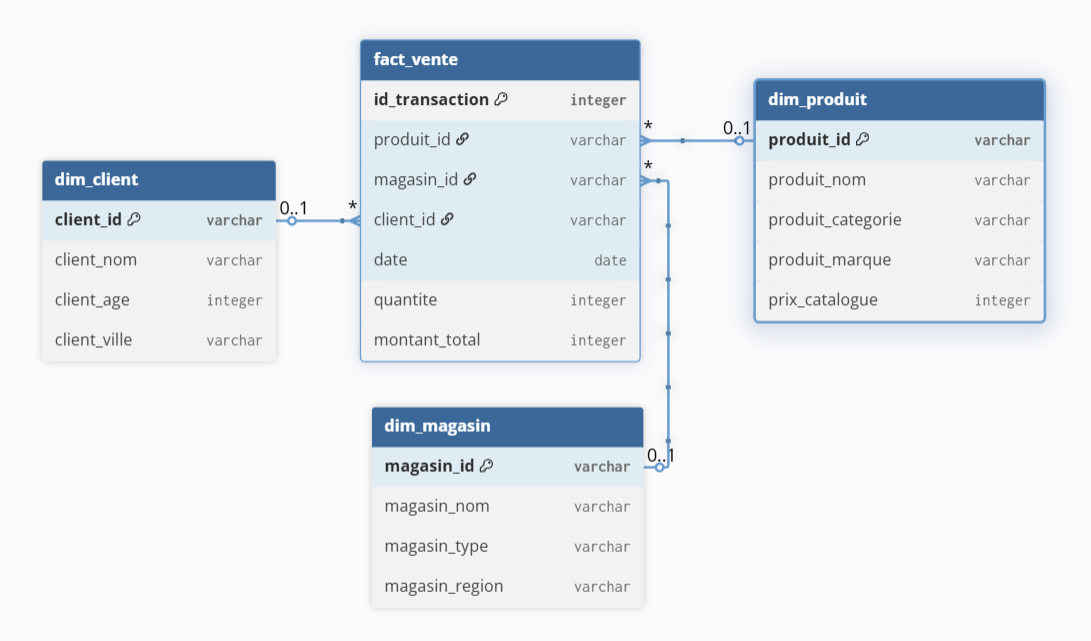

## Structure du projet dbt
```text
ventes/
├── models/
|   └── dim/
|   |   ├── dim_client.sql
|   |   ├── dim_magasin.sql
|   |   └── dim_produit.sql
|   └── fact/
|   |   └── fact_vente.sql
|   └── stg/
|       └── stg_vente.sql
└── tests/
```

Voici le contenu des fichiers les plus importants

In [ ]:
-- stg_vente.sql
-- Ce fichier récupère touts les données de la table vente. 
-- cela va nous servir de base pour alimenter les tables de dimensions et de fait
select * from vente

In [ ]:
-- dim_produit.sql
-- contient les informations liés au produit
-- on crée un id à partir du nom. On pourra facilement le recalculé dans la table de vente
select
    {{dbt_utils.generate_surrogate_key(['produit_nom'])}} as produit_id,
    produit_nom, 
    produit_categorie, 
    produit_marque, 
    prix_catalogue 
from {{ref('stg_vente')}}

In [ ]:
-- dim_client.sql
-- contient les informations liés au client
select 
    {{dbt_utils.generate_surrogate_key(['client_nom', 'client_age'])}} as client_id,
    client_nom, 
    client_age, 
    client_ville 
from {{ref('stg_vente')}}

In [ ]:
-- dim_magasin.sql
-- contient les informations liés au magasin
select 
    {{dbt_utils.generate_surrogate_key(['magasin_nom', 'magasin_region'])}} as magasin_id,
    magasin_nom, 
    magasin_type,
    magasin_region 
from {{ref('stg_vente')}}

In [ ]:
-- fact_vente.sql
-- Contient les informations d'une transaction
-- On recalcule les clé des différentes tables de dimensions. On s'en servira pour réaliser nos jointures
select
    id_transaction,
    {{dbt_utils.generate_surrogate_key(['produit_nom'])}} as produit_id,
    {{dbt_utils.generate_surrogate_key(['magasin_nom', 'magasin_region'])}} as magasin_id,
    {{dbt_utils.generate_surrogate_key(['client_nom', 'client_age'])}} as client_id,
    date,
    quantite,
    montant_total
from {{ref('stg_vente')}}


Pour matérialiser l'étoile avec dbt il faut lancer les commandes suivantes depuis le dossier `./ventes/` 
```sh
dbt deps # nécessaire uniquement la première fois
dbt run --profiles-dir .
```
Dbt créera automatiquement les tables de dimensions et celle de fait à côté de la table de ventes (dans la db `ventes_clean.duckdb`)

# Analyses des données

## Analyse temporelle

Quel est le chiffre d’affaires mensuel de la boutique ?

In [4]:
def sql(query) -> pandas.DataFrame:
    with duckdb.connect(db_path, read_only=True) as con:
        return con.sql(query).to_df()

<Axes: title={'center': "Chiffre d'affaires mensuel"}, xlabel='month'>

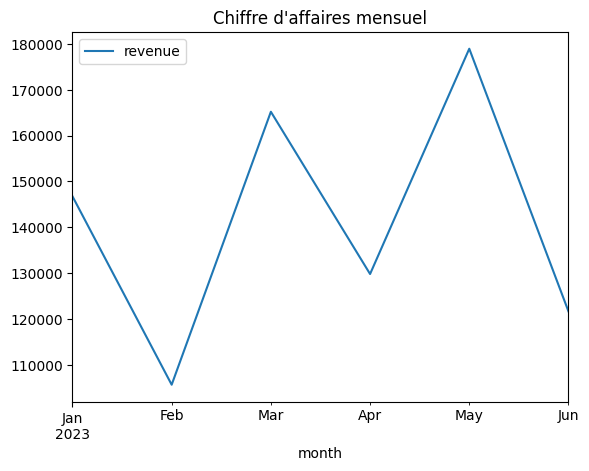

In [ ]:
avg_basket_per_day = """
SELECT 
    date_trunc('month', date) as month, 
    SUM(montant_total) as revenue
FROM fact_vente
GROUP BY month
ORDER BY month ASC;
"""

sql(avg_basket_per_day).plot(x="month", y="revenue", title="Chiffre d'affaires mensuel")


Quels sont les mois les plus rentables de l’année ?


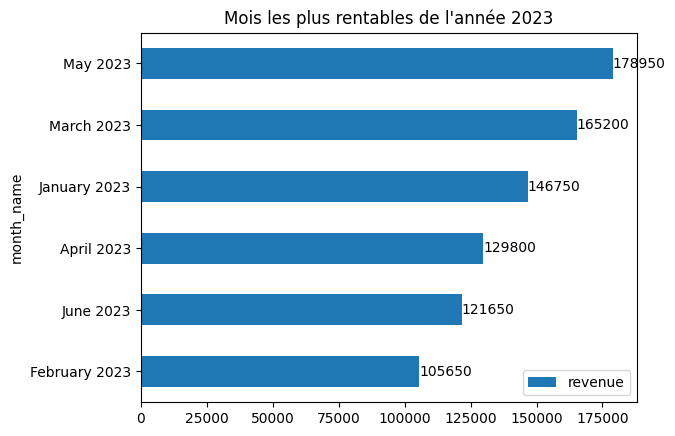

In [ ]:
avg_basket_per_day = """
SELECT 
    date_trunc('month', date) as month, 
    SUM(montant_total) as revenue
FROM fact_vente
WHERE year(date) = 2023
GROUP BY month
ORDER BY revenue ASC;
"""

data = sql(avg_basket_per_day) 
data["month_name"] = data["month"].dt.strftime("%B %Y")
p = data.plot.barh(x="month_name", y="revenue", title="Mois les plus rentables de l'année 2023")
_ = p.bar_label(p.containers[0])

Quelle est l’évolution du panier moyen (montant_total / transaction) au fil du temps ?


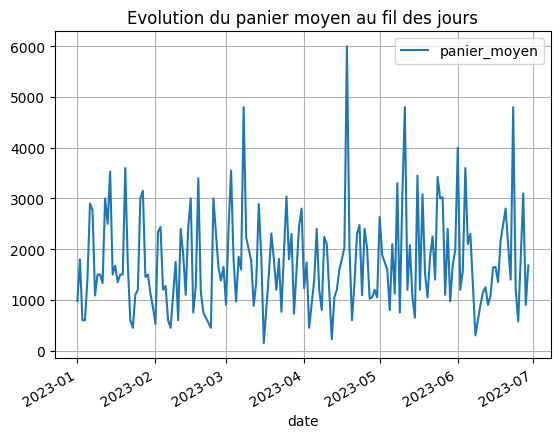

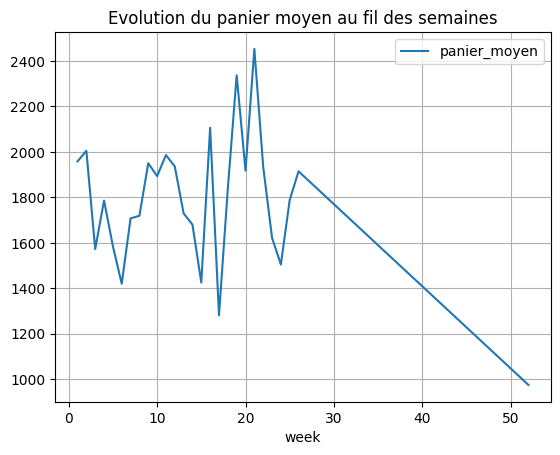

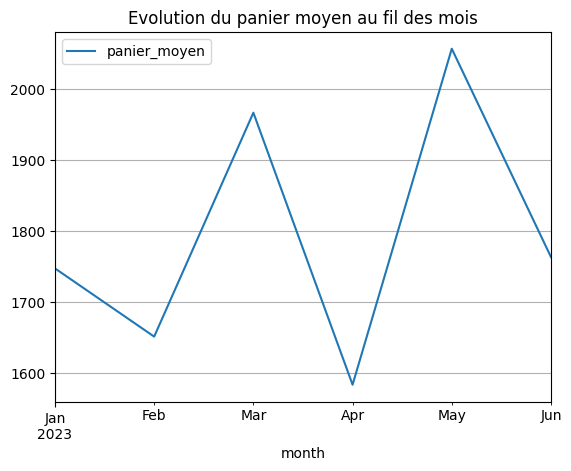

In [ ]:
avg_basket_per_day = """
SELECT 
    date, 
    AVG(montant_total) as panier_moyen 
FROM fact_vente 
GROUP BY date 
ORDER BY date ASC;
"""
data = sql(avg_basket_per_day)
data.plot(
    x="date",
    y="panier_moyen",
    title="Evolution du panier moyen au fil des jours",
    grid=True,
)

avg_basket_per_week = """
SELECT 
    datepart('week', date) as week, 
    AVG(montant_total) as panier_moyen 
FROM fact_vente 
GROUP BY week
ORDER BY week ASC;
"""
data = sql(avg_basket_per_week)
data.plot(
    x="week",
    y="panier_moyen",
    title="Evolution du panier moyen au fil des semaines",
    grid=True,
)

avg_basket_per_month = """
SELECT 
    date_trunc('month', date) as month, 
    AVG(montant_total) as panier_moyen 
FROM fact_vente 
GROUP BY month
ORDER BY month ASC;
"""
data = sql(avg_basket_per_month)
_ = data.plot(
    x="month",
    y="panier_moyen",
    title="Evolution du panier moyen au fil des mois",
    grid=True,
)
# TODO: avec radio button

## Analyse produit

Quels sont les produits les plus vendus en quantité ?


Text(0.5, 0, '')

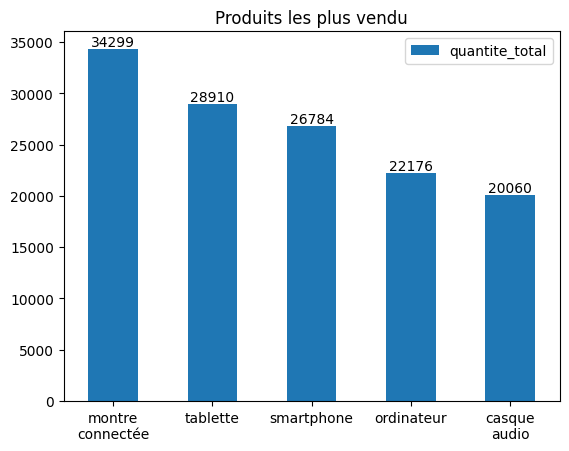

In [ ]:
query = """
SELECT 
    produit_nom, 
    SUM(quantite) AS quantite_total
FROM fact_vente
JOIN dim_produit ON dim_produit.produit_id = fact_vente.produit_id
GROUP BY produit_nom
ORDER BY quantite_total DESC;
"""

data = sql(query)
data["produit_nom"] = data["produit_nom"].str.replace(" ", "\n")
plt = data.plot.bar(y="quantite_total", x="produit_nom", title="Produits les plus vendu")
plt.bar_label(plt.containers[0])
plt.tick_params(axis="x", labelrotation=0)
plt.set_xlabel("")

Quels produits génèrent le plus de chiffre d’affaires ?


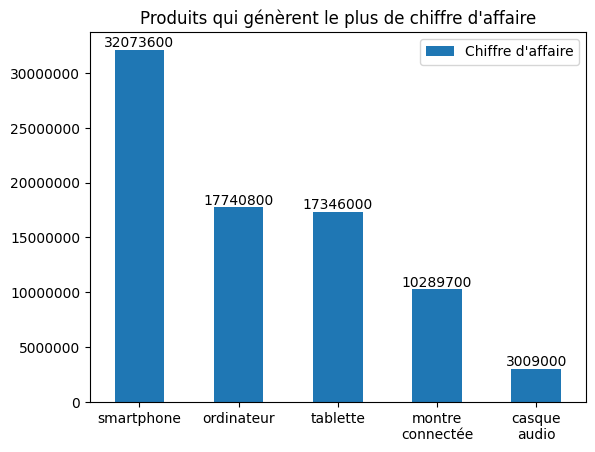

In [ ]:
query = """
SELECT 
    produit_nom, 
    SUM(montant_total) as total_product_revenue, 
FROM fact_vente
JOIN dim_produit ON dim_produit.produit_id = fact_vente.produit_id
GROUP BY produit_nom
ORDER BY total_product_revenue DESC;
"""

data = sql(query)

data["produit_nom"] = data["produit_nom"].str.replace(" ", "\n")

title = "Produits qui génèrent le plus de chiffre d'affaire"
plt = data.plot.bar(
    y="total_product_revenue",
    x="produit_nom",
    xlabel="",
    title=title,
)
plt.legend(labels=["Chiffre d'affaire"])
plt.ticklabel_format(axis="y", style="plain")
plt.bar_label(plt.containers[0], fmt="%.0f")
plt.tick_params(axis="x", labelrotation=0)

Quelles catégories de produits sont les plus populaires ?


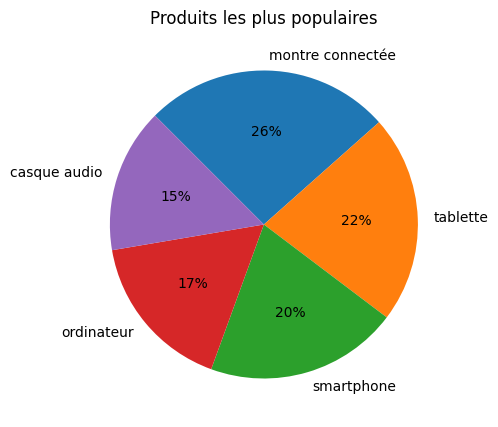

In [ ]:
query="""
SELECT 
    produit_nom, 
    SUM(quantite) as quantite_vendu, 
FROM fact_vente
JOIN dim_produit ON dim_produit.produit_id = fact_vente.produit_id
GROUP BY produit_nom
ORDER BY quantite_vendu DESC;
"""

data = sql(query)
title = "Produits les plus populaires"

plt = data.plot.pie(
    y="quantite_vendu",
    xlabel="",
    ylabel="",
    labels=data.produit_nom.to_list(),
    legend=None,
    figsize=(5,5),
    title=title,
    autopct="%1.0f%%",
    counterclock=False,
    startangle=135
)
# legend = plt.figure.legend(labels=data.produit_nom.to_list())


## Analyse client

Quelle est la répartition des ventes par tranche d’âge (10 ans) ?

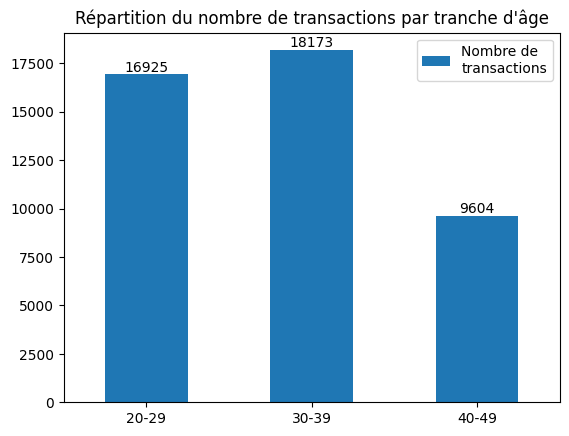

In [20]:
query = """
SELECT
    COUNT(*) AS transaction_total,
    SUM(quantite) AS produit_vendu,
    trunc(client_age, -1) AS tranche_age
FROM fact_vente
JOIN dim_client ON fact_vente.client_id = dim_client.client_id
GROUP BY tranche_age
ORDER BY tranche_age ASC;
"""

data = sql(query)
data["display_age"] = data["tranche_age"].apply(lambda age: f"{age}-{age+9}")
plt = data.plot(
    kind="bar",
    x="display_age",
    xlabel="",
    title="Répartition du nombre de transactions par tranche d'âge",
    y="transaction_total",
)
plt.legend(labels=["Nombre de\ntransactions"])
plt.bar_label(plt.containers[0])
plt.tick_params(axis="x", labelrotation=0)


Quelle ville ou région génère le plus de ventes ?
